In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from gensim.models import Word2Vec, Phrases
pd.set_option('display.max_columns', 200)
sns.set()

In [2]:
listing = pd.read_csv('./listings.csv')

/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
listing.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20200212052255,2020-02-12,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,NaN,NaN,https://a0.muscache.com/im/pictures/b7c2a199-4...,NaN,1169,https://www.airbnb.com/users/show/1169,Holly,2008-07-31,"San Francisco, California, United States",We are a family with 2 boys born in 2009 and 2...,within an hour,100%,99%,t,https://a0.muscache.com/im/pictures/user/efdad...,https://a0.muscache.com/im/pictures/user/efdad...,Duboce Triangle,1,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Lower Haight,Western Addition,NaN,San Francisco,CA,94117,San Francisco,"San Francisco, CA",US,United States,37.76931,-122.43386,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",NaN,$170.00,"$1,120.00","$4,200.00",$100.00,$100.00,2,$25.00,1,30,1,1,30,30,1.0,30.0,2 weeks ago,t,3,5,8,54,2020-02-12,233,54,2009-07-23,2020-01-05,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,STR-0001256,"{""SAN FRANCISCO""}",t,f,moderate,f,f,1,1,0,0,1.81
1,5858,https://www.airbnb.com/rooms/5858,20200212052255,2020-02-12,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,All the furniture in the house was handmade so...,The train is two blocks away and you can stop ...,"Our deck, garden, gourmet kitchen and extensiv...",NaN,"Please respect the house, the art work, the fu...",NaN,NaN,https://a0.muscache.com/im/pictures/17714/3a7a...,NaN,8904,https://www.airbnb.com/users/show/8904,Philip And Tania,2009-03-02,"San Francisco, California, United States",Philip: English transplant to the Bay Area and...,within a day,90%,82%,f,https://a0.muscache.com/im/users/8904/profile_...,https://a0.muscac

In [37]:
np.sum(listing.isnull(), axis=0)

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
summary                                          220
space                                           1297
description                                       54
experiences_offered                                0
neighborhood_overview                           2259
notes                                           3424
transit                                         2709
access                                          3388
interaction                                     2835
house_rules                                     2370
thumbnail_url                                   8587
medium_url                                      8587
picture_url                                        0
xl_picture_url                                

https://rstudio-pubs-static.s3.amazonaws.com/407929_afc5ef0f2ad648389447a6ca3f4a7cd4.html <br>
Based on the suggestion and our exploration, the first model will use below columns. <br>
The business context is -> We want to make the pricing suggestion for the user.

In [47]:
used_columns_numerical = ['host_since', 'host_location', 'host_is_superhost', 'host_has_profile_pic',
                          'host_identity_verified', 'host_response_time', 'host_response_rate',
                          'host_acceptance_rate', 'neighbourhood_cleansed', 'property_type', 'room_type',
                          'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
                          'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
                          'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                          'review_scores_value', 'cancellation_policy', 'require_guest_profile_picture',
                          'require_guest_phone_verification', 'calculated_host_listings_count']
used_columns_text = ['summary', 'description']
y = ['price']

In [396]:
len(used_columns_numerical)

33

For we want to make the dataset static at the first place. i.e. after we add variable, we won't change the total # of data because of None value or etc.

In [48]:
listing_final = listing[used_columns_numerical + used_columns_text + y].dropna(how='any')

In [49]:
listing_final.shape

(4579, 36)

# Fit with numerical information

In [51]:
listing_numerical = listing_final[used_columns_numerical]

In [52]:
listing_numerical.head(3)

,host_since,host_location,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,2008-07-31,"San Francisco, California, United States",t,t,t,within an hour,100%,99%,Western Addition,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",$100.00,$100.00,2,$25.00,1,233,10.0,10.0,10.0,10.0,10.0,9.0,moderate,f,f,1
2,2009-06-17,"San Francisco, California, United States",t,t,t,within an hour,100%,86%,Haight Ashbury,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",$200.00,$50.00,1,$12.00,32,18,8.0,8.0,9.0,9.0,9.0,8.0,strict_14_with_grace_period,f,f,9
3,2009-06-17,"San Francisco, California, United States",t,t,t,within an hour,100%,86%,Haight Ashbury,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",$200.00,$50.00,1,$12.00,32,8,9.0,9.0,10.0,10.0,9.0,9.0,strict_14_with_grace_period,f,f,9


### Data preprocessing

In [233]:
listing_numerical = listing_final[used_columns_numerical]
one_hot_columns = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type',
                   'bed_type', 'cancellation_policy']
count_columns = ['amenities']
listing_numerical = pd.get_dummies(listing_numerical, columns=one_hot_columns, drop_first=True)
listing_numerical['amenities'] = listing_numerical.apply(lambda row: len(row.amenities.split(',')),
                                                         axis=1)
listing_numerical['host_location'] = listing_numerical.apply(lambda row: True if row.host_location == 'San Francisco, California, United States' else False,
                                                                 axis=1)
listing_numerical['host_is_superhost'] = listing_numerical.apply(lambda row: True if row.host_is_superhost == 't' else False,
                                                                 axis=1)
listing_numerical['host_has_profile_pic'] = listing_numerical.apply(lambda row: True if row.host_has_profile_pic == 't' else False,
                                                                 axis=1)
listing_numerical['host_identity_verified'] = listing_numerical.apply(lambda row: True if row.host_identity_verified == 't' else False,
                                                                 axis=1)
listing_numerical['host_response_rate'] = listing_numerical.apply(lambda row: float(row.host_response_rate.strip('%')),
                                                                 axis=1)
listing_numerical['host_acceptance_rate'] = listing_numerical.apply(lambda row: float(row.host_acceptance_rate.strip('%')),
                                                                 axis=1)
listing_numerical['security_deposit'] = listing_numerical.apply(lambda row: float(row.security_deposit.strip('$').replace(',', '')),
                                                                 axis=1)
listing_numerical['cleaning_fee'] = listing_numerical.apply(lambda row: float(row.cleaning_fee.strip('$').replace(',', '')),
                                                                 axis=1)
listing_numerical['extra_people'] = listing_numerical.apply(lambda row: float(row.extra_people.strip('$').replace(',', '')),
                                                                 axis=1)
listing_numerical['require_guest_profile_picture'] = listing_numerical.apply(lambda row: True if row.require_guest_profile_picture == 't' else False,
                                                                 axis=1)
listing_numerical['require_guest_phone_verification'] = listing_numerical.apply(lambda row: True if row.require_guest_phone_verification == 't' else False,
                                                                 axis=1)
listing_numerical['host_since'] = listing_numerical.apply(lambda row: datetime.strptime(row.host_since, '%Y-%m-%d'),
                                                          axis=1)
listing_numerical['host_since'] = pd.DatetimeIndex(listing_numerical['host_since']).astype(np.int64) // 10 ** 9

y = listing_final.apply(lambda row: float(row.price.strip('$').replace(',', '')),axis=1)

In [395]:
listing_numerical.head(3)

,host_since,host_location,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Apartment,property_type_Bed and breakfast,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Castle,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tiny house,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1217462400,True,True,True,True,100.0,99.0,3,1.0,1.0,2.0,34,100.0,100.0,2,25.0,1,233,10.0,10.0,10.0,10.0,10.0,9.0,False,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,1245196800,True,True,True,True,100.0,86.0,2,4.0,1.0,1.0,18,200.0,50.0,1,12.0,32,18,8.0,8.0,9.0,9.0,9.0,8.0,False,False,9,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
3,1245196800,True,True,True,True,100.0,86.0,2,4.0,1.0,1.0,16,200.0,50.0,1,12.0,32,8,9.0,9.0,10.0,10.0,9.0,9.0,False,False,9,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


In [398]:
listing_numerical.shape

(4579, 97)

### Train Test Split

In [346]:
X_train, X_test, y_train, y_test = train_test_split(listing_numerical, y,
                                                    test_size=0.2, random_state=42)

### Fit Lasso 

In [358]:
def print_metric(X_train, X_test, y_train, y_test, estimator):
    print('In sample R-squared: ', r2_score(y_train, estimator.predict(X_train)))
    print('Out of sample R-squared: ', r2_score(y_test, estimator.predict(X_test)))
    print('In sample MSE: ', mean_squared_error(y_train, estimator.predict(X_train)))
    print('Out of sample MSE: ', mean_squared_error(y_test, estimator.predict(X_test)))

In [359]:
lasso = LassoCV(normalize=True)

In [360]:
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [361]:
print_metric(X_train, X_test, y_train, y_test, lasso)

In sample R-squared:  0.5260578471827375
Out of sample R-squared:  0.5848867267023228
In sample MSE:  19727.94457860417
Out of sample MSE:  15514.789632359389


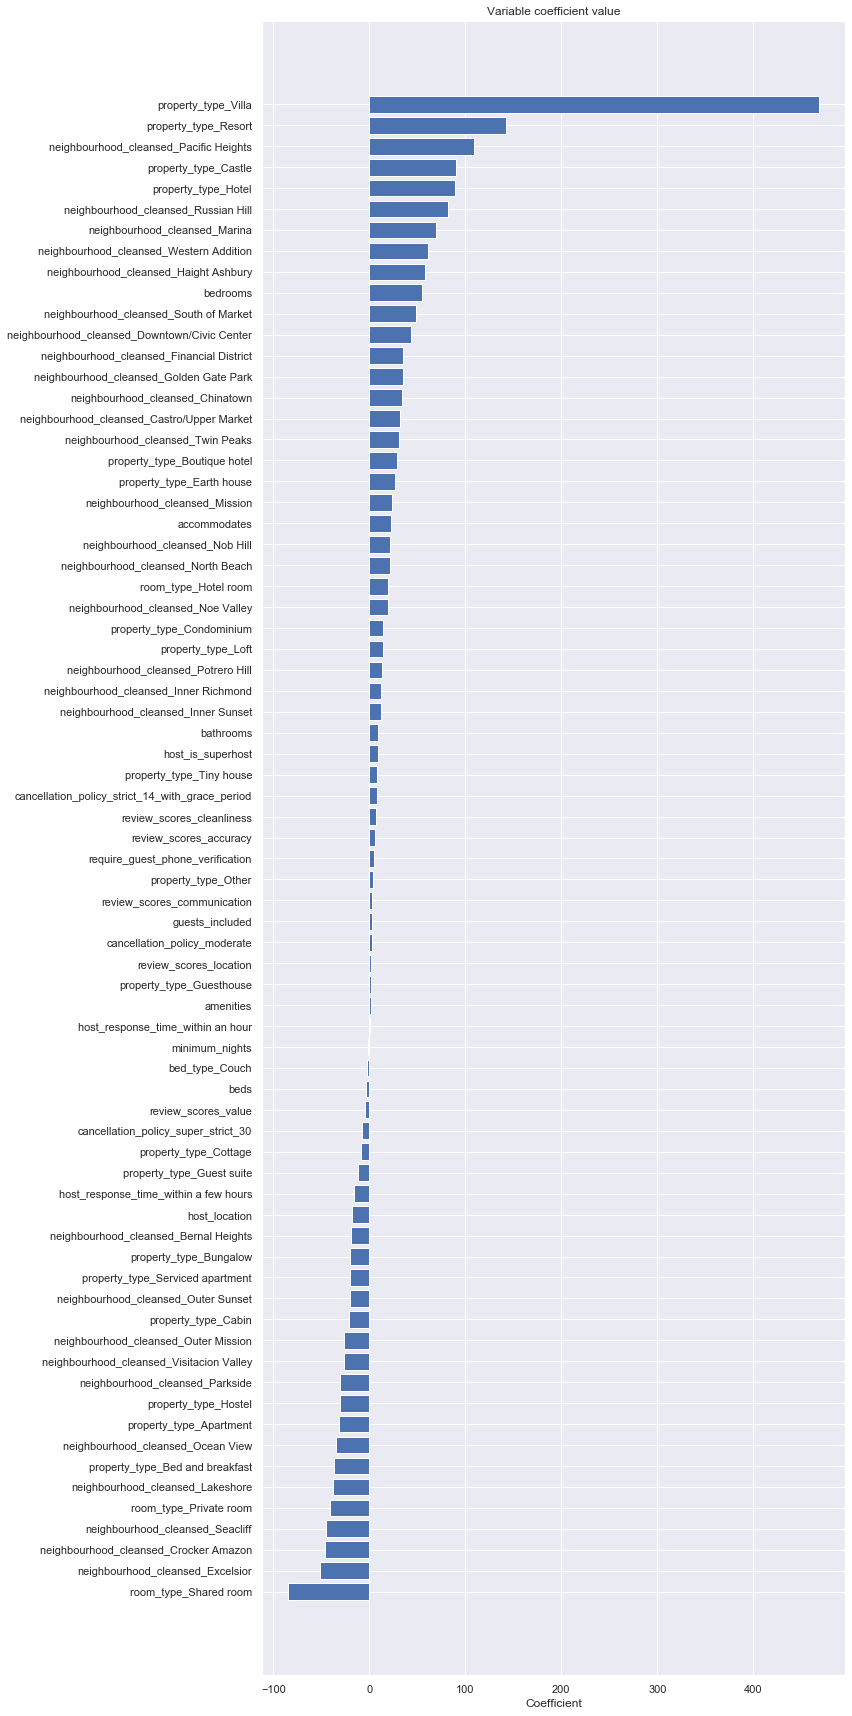

In [420]:
coef = lasso.coef_[np.abs(lasso.coef_) > 10e-1]
# make importances relative to max importance
sorted_idx = np.argsort(coef)
pos = np.arange(sorted_idx.shape[0])
plt.figure(figsize=(12, 24))
plt.barh(pos, coef[sorted_idx], height=0.8, align='center')
plt.yticks(pos, listing_numerical.columns[np.abs(lasso.coef_) > 10e-1][sorted_idx])
plt.xlabel('Coefficient')
plt.title('Variable coefficient value')
plt.tight_layout()
plt.savefig('Lasso.png', bbox='tight')
plt.show()

### Fit with gradient boosting machine

In [347]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'n_iter_no_change': 3, 'random_state':42}
clf = GradientBoostingRegressor(**params)

In [348]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=3, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [349]:
print_metric(X_train, X_test, y_train, y_test, clf)

In sample R-squared:  0.6750594935271641
Out of sample R-squared:  0.6279412084829636
In sample MSE:  13525.718834955225
Out of sample MSE:  13905.6355278654


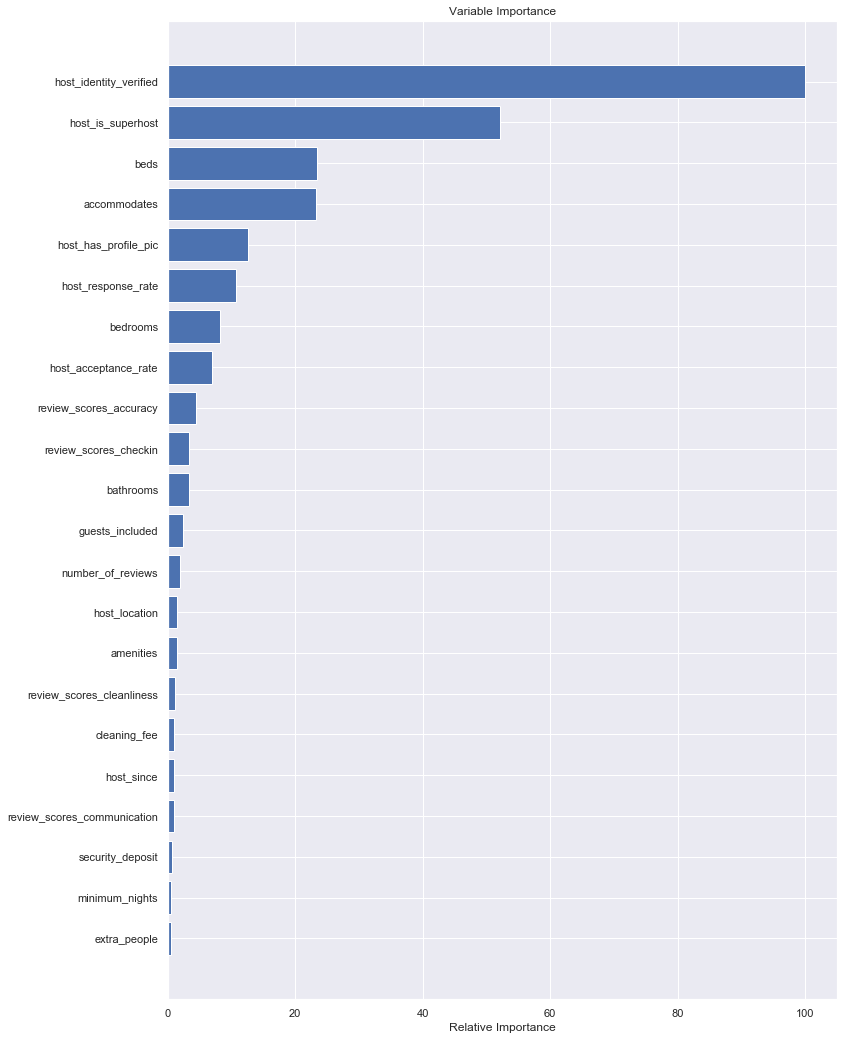

In [425]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance = feature_importance[feature_importance > 0.5]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, listing_numerical.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Train the model with data filtered based on review_score_value 

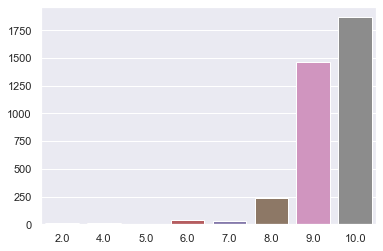

In [377]:
sns.barplot(x=X_train.review_scores_value.value_counts().keys(),
            y=X_train.review_scores_value.value_counts().values)                  

In [382]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'n_iter_no_change': 3, 'random_state':42}
clf_non_filter = GradientBoostingRegressor(**params)
clf_filtered = GradientBoostingRegressor(**params)
clf_non_filter.fit(X_train, y_train)
clf_filtered.fit(X_train[X_train.review_scores_value == 10], y_train[X_train[X_train.review_scores_value == 10].index])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=3, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

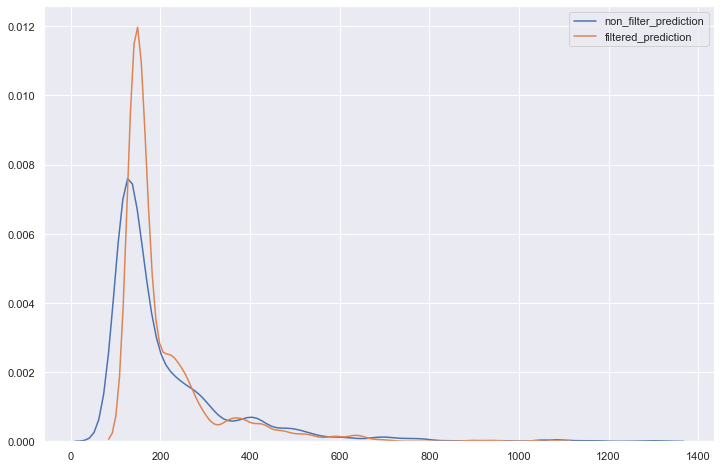

In [392]:
non_filter_price = clf_non_filter.predict(X_test)
filtered_price = clf_filtered.predict(X_test)
plt.figure(figsize=(12, 8))
sns.distplot(non_filter_price, hist=False, label='non_filter_prediction')
sns.distplot(filtered_price, hist=False, label='filtered_prediction')
plt.legend()
plt.show()

#### If we assume those units which review_score_value have 10 scores are all 'good pricing', then the conclusion is: this optimal pricing model will predict the price to be lower and more centralized.

### Is summary affecting the performance of model? -> NO

In [330]:
corpus = listing['summary'].dropna().tolist() + listing['description'].dropna().tolist()
corpus = [text.split(' ') for text in corpus]
model = Word2Vec(corpus, size=300, window=5, min_count=1, workers=4)

In [338]:
wv_dict = {}
for ind, text in zip(listing_final.index, listing_final.description):
    wv_dict[ind] = np.mean([model.wv[voc] if voc in model.wv else 0 for voc in text], axis=0)

In [339]:
listing_full = pd.concat([listing_numerical, pd.DataFrame(wv_dict).transpose()], axis=1)

In [340]:
X_train, X_test, y_train, y_test = train_test_split(listing_full, y,
                                                    test_size=0.2, random_state=42)

In [341]:
lasso = LassoCV(normalize=True)
lasso.fit(X_train, y_train)
print_metric(X_train, X_test, y_train, y_test, lasso)

/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23408.705243214965, tolerance: 12488.39274679181
  tol, rng, random, positive)
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24329.704330205917, tolerance: 12488.39274679181
  tol, rng, random, positive)
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15935.90831360966, tolerance: 12488.39274679181
  tol, rng, random, positive)
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472

/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27897.328875005245, tolerance: 12215.963375844423
  tol, rng, random, positive)
/Users/wangyaoting/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83005.5179483369, tolerance: 12215.963375844423
  tol, rng, random, positive)


In sample R-squared:  0.5248528222547045
Out of sample R-squared:  0.5838405931930899
In sample MSE:  19778.104001763215
Out of sample MSE:  15553.88869848699


In [342]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'n_iter_no_change': 3}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=3, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [343]:
print_metric(X_train, X_test, y_train, y_test, clf)

In sample R-squared:  0.6086514040617359
Out of sample R-squared:  0.5742036815365257
In sample MSE:  16289.969916563676
Out of sample MSE:  15914.066670801574
